In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [3]:
class TrafficSimulator1Lane:
    
    def __init__(self, initial_density, length, v_max, p_slow_down, random_v = False): 
        #Simulator parameters
        self.initial_density = initial_density
        self.length = length
        self.v_max = v_max
        self.p_slow_down = p_slow_down
        
        #Building the initial state
        self.current_state = -np.ones(self.length)
        if random_v: 
            choices = np.random.choice(self.length, size=int(self.initial_density*self.length), replace=False)
            for i in choices:
                self.current_state[i] = np.random.choice(range(1, self.v_max), size=1)
        else: 
            self.current_state[np.random.choice(self.length, size=int(self.initial_density*self.length), replace=False)] \
            = 0
        self.next_state = np.copy(self.current_state)
        
        #Time-keeping and other logs
        self.time = 0
        self.q = []
    
    def flow_count(self): 
        count = 0
        for i in range(1, self.v_max+1): 
            if self.current_state[-i] >= i: 
                count += 1
        return count
    
    def increment_time(self): 
        ##Calculating new velocities
        car_indices = (self.next_state > -1)
        car_below_maxv_indices = (self.next_state < self.v_max)
        #increment all velocity by 1, if < v_max
        self.next_state += np.array(car_indices*car_below_maxv_indices, dtype=int)
        #figure out where the cars are, including first car new relative position
        # because of the periodic boundary
        car_where = np.where(car_indices == 1)
        car_where = np.append(car_where, car_where[0][0] + self.length)
        #count the distance between cars
        car_distance_counts = np.ediff1d(car_where) - 1
        car_distance = -np.ones(shape=self.length)
        car_distance[np.where(car_indices == 1)[0]] = car_distance_counts
        #calculate deterministic new velocities, by element-wise minimum of increase velocity and distance
        self.next_state = np.minimum(self.next_state, car_distance)
        #randomly decrease velocity, due to driver behaviors
        car_above_minv_indices = (self.next_state > 0)
        random_decrease = (np.random.uniform(size=self.length) < self.p_slow_down)
        self.next_state -= (car_above_minv_indices*random_decrease)
        
        ##Counting the flow in this step
        self.q.append(self.flow_count())            
        
        ##Moving the cars
        self.current_state = -np.ones(shape=self.current_state.shape)
        next_positions = (np.where(self.next_state > -1)[0] + self.next_state[car_indices])%self.length
        self.current_state[np.array(next_positions, dtype=int)] = self.next_state[car_indices]
        
        self.next_state = np.copy(self.current_state)
        self.time += 1
        
        
    def display(self):
        print(''.join('-' if x == -1 else str(int(x)) for x in self.current_state))

In [ ]:
#low density
sim = TrafficSimulator1Lane(0.03, 10**4, 5, 0.5, random_v = True)

import time
start = time.time()
for _ in range(10**3): 
    sim.increment_time()

print(time.time() - start)

In [ ]:
#high density
sim = TrafficSimulator1Lane(0.1, 100, 5, 0.5, random_v = True)

for _ in range(100): 
    sim.display()
    sim.increment_time()

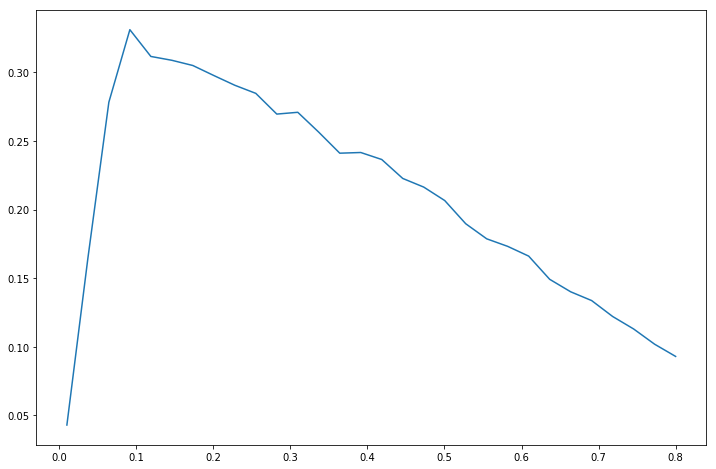

In [5]:
def run_traffic_simulation(n, initial_density):
    flow_density = []
    for _ in range(n):
        sim = TrafficSimulator1Lane(initial_density, 10**4, 5, 0.5, random_v = True)
        for _ in range(10**3): 
            sim.increment_time()
        flow_density.append(sum(sim.q)/len(sim.q))
    return flow_density

initial_density = np.linspace(0.01, 0.8, 30)

q = []
for density in initial_density:
    one = run_traffic_simulation(10, density)
    q.append(sum(one)/len(one))

plt.figure(figsize=(12,8))
plt.plot(initial_density, q)
plt.show()